          id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731

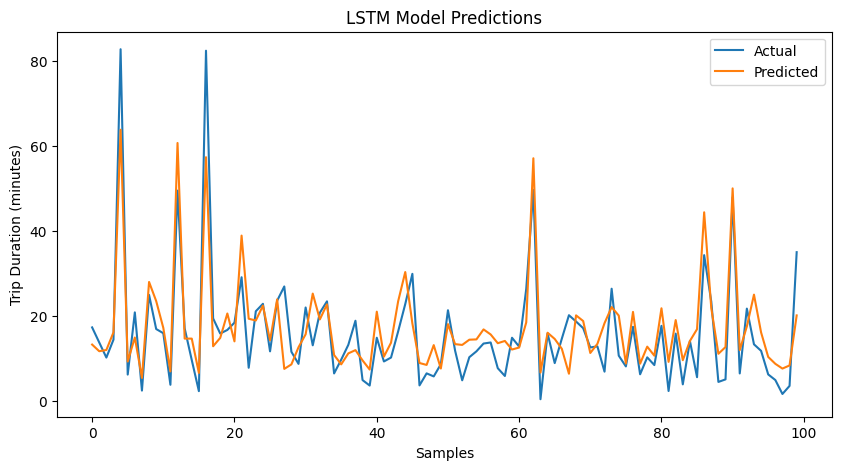

item_id        1         2         3         4         5         6         7   \
user_id                                                                         
1        0.498188  0.493642  0.564104  0.517874  0.509688  0.486540  0.467136   
2        0.461977  0.471064  0.474405  0.504691  0.487113  0.501189  0.492381   
3        0.495610  0.512058  0.496792  0.555273  0.523603  0.468227  0.485507   
4        0.469644  0.511042  0.537620  0.493313  0.508377  0.551553  0.471720   
5        0.480501  0.487782  0.457284  0.487390  0.523318  0.502785  0.468418   

item_id        8         9         10  ...        90        91        92  \
user_id                                ...                                 
1        0.497050  0.555633  0.479134  ...  0.537367  0.429996  0.483245   
2        0.524485  0.442948  0.514833  ...  0.552549  0.467524  0.485365   
3        0.520391  0.496788  0.461666  ...  0.469012  0.481857  0.566619   
4        0.487846  0.496274  0.494749  ...  0.458704

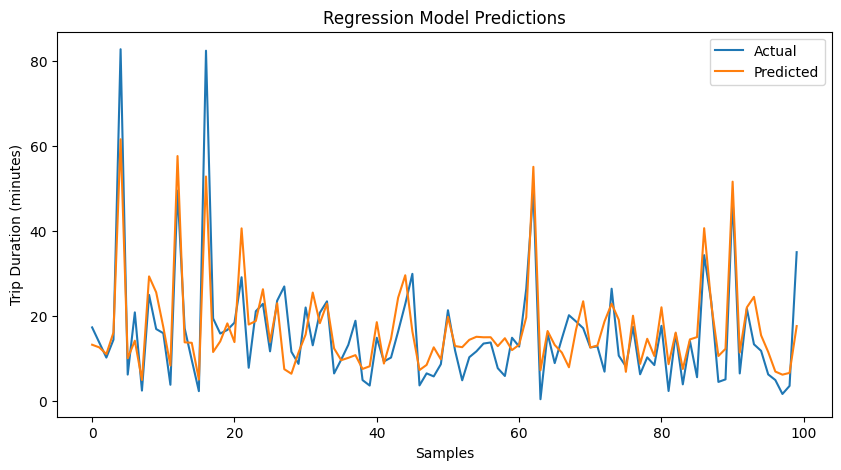

   trip_duration incentive
0       7.583333       Low
1      11.050000       Low
2      35.400000      High
3       7.150000       Low
4       7.250000       Low
Epoch 1/5
36467/36467 [==============================] - 107s 3ms/step - loss: 8713.9570
Epoch 2/5
36467/36467 [==============================] - 95s 3ms/step - loss: 8708.9492
Epoch 3/5
36467/36467 [==============================] - 92s 3ms/step - loss: 8707.7764
Epoch 4/5
36467/36467 [==============================] - 96s 3ms/step - loss: 8707.1201
Epoch 5/5
9117/9117 [==============================] - 17s 2ms/step
ETA Prediction Model MSE: 2859.5260182117554
ETA Prediction Model MAE: 6.636560064311685


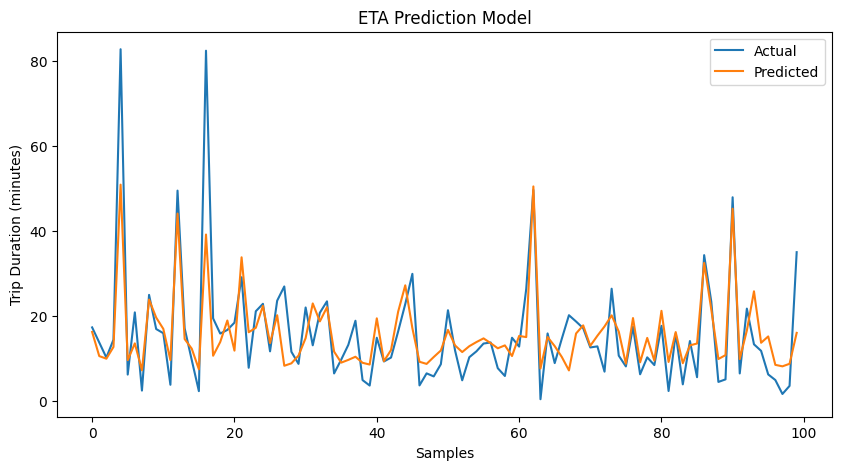

In [5]:
# !pip install pandas numpy scikit-learn tensorflow keras matplotlib

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Load the NYC Taxi dataset (local file)
data = pd.read_csv('train.csv')

# Data overview
print(data.head())

# Data preprocessing
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['pickup_datetime']) + pd.to_timedelta(data['trip_duration'], unit='s')
data['trip_duration'] = data['trip_duration'] / 60  # Convert trip duration to minutes

# Feature engineering
data['hour'] = data['pickup_datetime'].dt.hour
data['day_of_week'] = data['pickup_datetime'].dt.dayofweek
data['month'] = data['pickup_datetime'].dt.month

# Calculate trip distance (haversine distance)
def haversine(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

data['trip_distance'] = haversine(data['pickup_latitude'], data['pickup_longitude'],
                                  data['dropoff_latitude'], data['dropoff_longitude'])

# Select relevant features
features = ['hour', 'day_of_week', 'month', 'trip_distance', 'passenger_count']
target = 'trip_duration'

# Drop rows with missing values
data = data.dropna(subset=features + [target])

# Split data into training and test sets
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Capacity Planning: Time Series Forecasting with LSTM
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Reshape data for LSTM
X_train_lstm = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

lstm_model = create_lstm_model()
lstm_model.fit(X_train_lstm, y_train, epochs=5, batch_size=32)

# Predict and evaluate LSTM model
y_pred_lstm = lstm_model.predict(X_test_lstm)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
print(f'LSTM Model MSE: {mse_lstm}')
print(f'LSTM Model MAE: {mae_lstm}')

# Plot LSTM results
plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:100], label='Actual')
plt.plot(y_pred_lstm[:100], label='Predicted')
plt.title('LSTM Model Predictions')
plt.xlabel('Samples')
plt.ylabel('Trip Duration (minutes)')
plt.legend()
plt.show()

# Driver Matching: Collaborative Filtering (Mock implementation)
# Note: Replace with actual collaborative filtering implementation as needed
user_ids = np.random.randint(1, 100, size=len(data))
item_ids = np.random.randint(1, 100, size=len(data))
ratings = np.random.rand(len(data))

collab_data = pd.DataFrame({'user_id': user_ids, 'item_id': item_ids, 'rating': ratings})

# Aggregate ratings to avoid duplicates
collab_data = collab_data.groupby(['user_id', 'item_id']).agg({'rating': 'mean'}).reset_index()

# Example: Simple user-item matrix
user_item_matrix = collab_data.pivot(index='user_id', columns='item_id', values='rating').fillna(0)
print(user_item_matrix.head())

# Dynamic Pricing: Regression Model
reg_model = GradientBoostingRegressor()
reg_model.fit(X_train, y_train)

y_pred_reg = reg_model.predict(X_test)
mse_reg = mean_squared_error(y_test, y_pred_reg)
mae_reg = mean_absolute_error(y_test, y_pred_reg)
print(f'Regression Model MSE: {mse_reg}')
print(f'Regression Model MAE: {mae_reg}')

# Plot Regression results
plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:100], label='Actual')
plt.plot(y_pred_reg[:100], label='Predicted')
plt.title('Regression Model Predictions')
plt.xlabel('Samples')
plt.ylabel('Trip Duration (minutes)')
plt.legend()
plt.show()

# Incentive Strategy: Analysis (Mock implementation)
# Example: Simple retention strategy based on trip duration
data['incentive'] = np.where(data['trip_duration'] > 15, 'High', 'Low')
print(data[['trip_duration', 'incentive']].head())

# ETA Prediction: Neural Network
def create_eta_model():
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

eta_model = create_eta_model()
eta_model.fit(X_train, y_train, epochs=5, batch_size=32)

# Predict and evaluate ETA model
y_pred_eta = eta_model.predict(X_test)
mse_eta = mean_squared_error(y_test, y_pred_eta)
mae_eta = mean_absolute_error(y_test, y_pred_eta)
print(f'ETA Prediction Model MSE: {mse_eta}')
print(f'ETA Prediction Model MAE: {mae_eta}')

# Plot ETA results
plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:100], label='Actual')
plt.plot(y_pred_eta[:100], label='Predicted')
plt.title('ETA Prediction Model')
plt.xlabel('Samples')
plt.ylabel('Trip Duration (minutes)')
plt.legend()
plt.show()
